# A Basic Capacity Expansion Model

_**[Power Systems Optimization](https://github.com/east-winds/power-systems-optimization)**_

_by Jesse D. Jenkins and Michael R. Davidson (last updated: October 3, 2022)_

This notebook presents a basic electricity generation capacity expansion model: the task of minimizing the cost of fixed and variable costs across a fleet of generators to meet anticipated future electricity demand. 

We first present a basic optimization formulation of this optimal thermal generator capacity expansion problem, assuming a "greenfield" setting with no existing generating capacity. We also show how to create this model with Julia + JuMP.

Next, we discuss the impact of variable renewable energy sources (wind, solar) and present a slightly modified formulation that co-optimizes thermal and renewable capacities. 

Finally, we will note how this problem generalizes to a "brownfield" expansion problem including existing generators, with optimal retirement decisions included in the problem.

Note these capacity expansion problems will be basic/simplified formulations, ignoring inter-temporal operating constraints (e.g. ramp limits), energy storage, network constraints and geospatial tradeoffs, unit commitment decisions for thermal generators, and operating reserves. We will define a more complex model integrating these factors in a future notebook after familiarizing ourselves with operational models (economic dispatch, unit commitment, and optimal power flow).

## 1. Optimal thermal generator expansion problem

<img src="img/thermal.png" style="width: 450px; height: auto" align="left">

Assume a utility can build any of the following four thermal generation types: geothermal, coal, natural gas combined cycle gas turbine (CCGT), and natural gas combustion turbine (CT). The utility must decide on the mix of thermal generators to meet forecasted demand in a future planning year across each hour of the year. 

Assume for simplicity that there are no existing generators -- that is, this is a "greenfield" expansion problem where all generators are newly built. 

Finally, assume that any involuntary curtailment of demand caused by shortfalls in supply is penalized at the cost of non-served energy. (Note that by penalizing the opportunity cost of demand curtailment, this cost minimization problem is equivalent to a social welfare maximization problem, assuming inelastic demand). 

### Problem formulation

This yields the following **optimization problem**:

$\begin{align}
\min &\sum_{g \in G} \left(FixedCost_g \times CAP_g +  \sum_{h \in H} VarCost_g \times GEN_{g,h}\right)& \\
&\quad\quad+ \sum_{h \in H} NSECost \times NSE_h &\\[6pt]
&\text{s.t.}&\\[6pt]
& \sum_{g \in G} GEN_{g,h} + NSE_h = Demand_h & \forall \quad h \in H\\[6pt]
& GEN_{g,h} \leq CAP_g & \forall \quad g \in G \text{ \& } h \in H\\[6pt]
& CAP_{g} \geq 0 & \forall \quad g \in G\\[6pt]
& NSE_{h} \geq 0 & \forall \quad h \in H
& GEN_{g,h} \geq 0 & \forall \quad g \in G \text{ \& } h \in H\\
\end{align}$

And where:

$\begin{align}
&FixedCost_g = Capex_g \times CRF_g + FixedOM_g \quad \forall g \in G\\[6pt]
&CRF_g = \frac{WACC_g(1+WACC_g)^{Life_g}}{(1+WACC_g)^{Life_g}-1} \quad \forall g \in G\\[6pt]
&VarCost_g = VarOM_g + HeatRate_g \times FuelCost_g \quad \forall g \in G
\end{align}$

The **decision variables** in the above problem are:
- $CAP_{g}$, the capacity (in MW) built for each generation type, $g$; and
- $GEN_{g,h}$, the generation (in MWh) produced by each generator, $g$, in each hour, $h$; and
- $NSE_h$, the quantity of involuntarily curtailed demand in each hour (in MWh), $h$.

Note that if we ignore the discrete nature of large thermal power plant decisions (investment and power plant cycling decisions), we have continous decisions and *a linear programming (LP) problem* with linear objective function and linear constraints. (We'll incorporate discrete decisions in the notebook on Unit Commitment)

The **sets** are:
- $G$, the set of generators: \[geo, coal, CCGT, CT\];
- $H$, the set of hours in the year: \[1:8760\]

The **parameters** are:

- $Capex_g$, the capital expenditure to construct the power plant (overnight cost + cost of financing during construction) (\$/MW); 
- $CRF_g$,  the annual capital recovery factor or share of $Capex$ recovered in each year to pay off equity and debt (per unit);
- $WACC_g$,  the weighted average cost of capital to finance the generator, or the weighted cost of interest on debt and returns to equity investors (\%); 
- $Life_g$, the financial asset life of the asset (years); 
- $FixedOM_g$, the fixed operations and maintenance cost (\$/MW-year)
- $VarOM_g$, the variable operations and maintenance cost (\$/MWh);
- $HeatRate_g$, the rate of fuel consumed per unit of electricity produced (MMBtu/MWh);
- $FuelCost_g$, the cost of fuel (\$/MMBtu)
- $NSECost$, the opportunity cost or penalty incurred for involuntary non-served energy (\$/MWh); and
- $Demand_h$, is the demand in each hour

## Building the problem with Julia + JuMP

Now let's define this LP problem with the help of Julia + JuMP.

**1. Load packages**

First, let's load the Julia packages we'll need to work with here.

In [24]:
# Uncomment this line if you need to install these packages:
import Pkg; Pkg.add("JuMP"); Pkg.add("HiGHS"); Pkg.add("DataFrames"); Pkg.add("CSV"); Pkg.add("Statistics")
using JuMP, HiGHS
using Plots
using DataFrames, CSV, Statistics
ENV["COLUMNS"]=120 # Set so all columns of DataFrames and Matrices are displayed

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


120

**1. Load parameters (data)**

Then we'll load our parameters, starting with the cost parameters for the candidate generators.

The following generator data are illustrative and approximate, but most are based on the National Renewable Energy Laboratory's [Annual Technology Baseline 2020](https://atb.nrel.gov/electricity/2020/), except for natural gas CT capex, which is based on Lazard's [Levelized Cost of Electricity Version 13.0](https://www.lazard.com/media/451086/lazards-levelized-cost-of-energy-version-130-vf.pdf). 

In [25]:
generators = DataFrame(CSV.File("expansion_data/generators_for_expansion.csv"))

Row,G,Description,Capex,FixedOM,VarOM,HeatRate,FuelCost,WACC,AssetLife,CRF,Annuity,FixedCost,VarCost
,String7,String31,Int64,Int64,Int64,Float64,Int64,Float64,Int64,Float64,Int64,Int64,Float64
1,Geo,Geothermal,7500000,130000,0,28.4,0,0.04,30,0.0578,433500,563500,0.0
2,Coal,Supercritical Coal,2600000,120000,8,8.1,2,0.04,30,0.0578,150280,270280,24.2
3,CCGT,Natural gas CCGT,1000000,28000,2,6.4,4,0.035,30,0.0544,54400,82400,27.6
4,CT,Natural gas CT,770000,21000,5,9.7,4,0.035,30,0.0544,41888,62888,43.8
5,Wind,Onshore wind,1000000,40000,0,1.0,0,0.03,30,0.051,51000,91000,0.0
6,Solar,Tracking solar PV,750000,15000,0,1.0,0,0.025,30,0.0478,35850,50850,0.0


Note we've got wind and solar costs in here, but we'll get to these variable renewable resources in the next section.

Next we'll load the hourly demand data. This demand time series is the actual reported demand (from 2012) for San Diego Gas and Electric (via the [PowerGenome](https://github.com/gschivley/PowerGenome) data platform as reported to FERC Form 714).

In [26]:
demand = DataFrame(CSV.File("expansion_data/demand_for_expansion.csv"))

Row,Hour,Demand
,Int64,Int64
1,1,2274
2,2,2581
3,3,2576
4,4,2482
5,5,2396
6,6,2193
7,7,1929
8,8,1715
9,9,1555


Let's plot the demand to get a feel for what we're working with here...

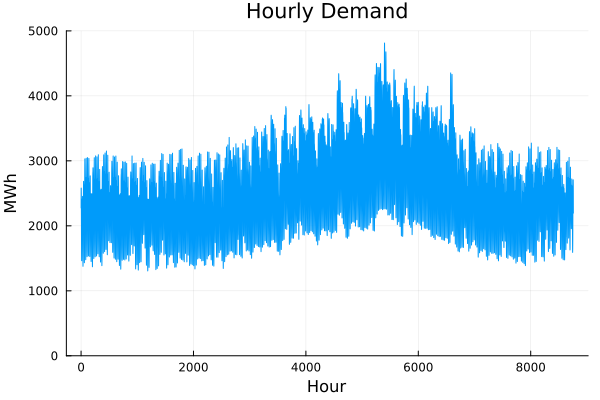

In [27]:
plot(demand.Demand, ylims=(0,5000), label="")
title!("Hourly Demand")
xaxis!("Hour")
yaxis!("MWh")

(Note that this time series starts at 0\:00-0\:59 [UTC](https://en.wikipedia.org/wiki/Coordinated_Universal_Time) time, or 5pm Pacific time)

You can see some of the seasonal trends here in San Diego electricity demand with some large peaks in demand in the summer months driven by air conditioning needs. This profile also includes the impact of about 600 MW of distributed solar PV installed behind the meter, which reduces the net load for the bulk generators we are planning here.

The chronological demand profile is a little hard to look at though, with all the daily variation, and since we're not considering intertemporal constraints (yet), let's resort the demand from highest to lowest hour of demand across the year, what is known as a **"load duration curve."**

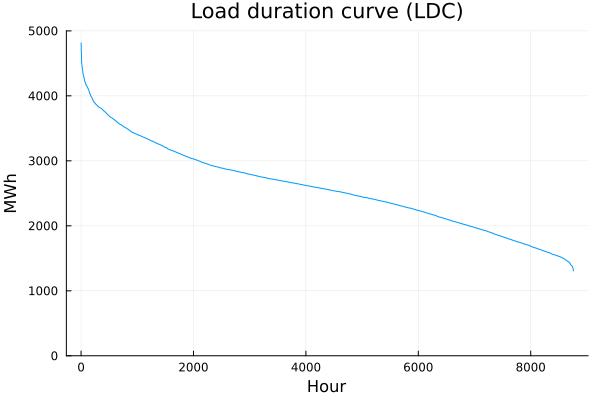

In [28]:
plot(sort(demand.Demand, rev=true), ylims=(0,5000), label="")
title!("Load duration curve (LDC)")
xaxis!("Hour")
yaxis!("MWh")

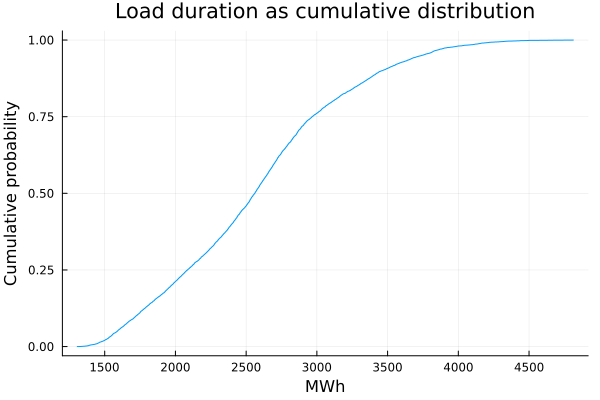

In [29]:
plot(sort(demand.Demand), range(0,1,length=8760), label="")
title!("Load duration as cumulative distribution")
yaxis!("Cumulative probability")
xaxis!("MWh")

Examining the load duration curve, we can more easily see the wide range of variation in hourly demand across the year...

In [30]:
print(string("Minimum demand: ",minimum(demand.Demand),"\n"))
print(string("Maximum demand: ",maximum(demand.Demand),"\n"))
print(string("Median demand: ",median(demand.Demand),"\n"))
print(string("Mean demand: ",round(mean(demand.Demand),digits=0),"\n"))

Minimum demand: 1306
Maximum demand: 4813
Median demand: 2561.0
Mean demand: 2576.0


Finally, we will set the penalty for non-served energy or $NSECost$ to \$9,000/MWh

In [31]:
NSECost = 9000

9000

**3. Define sets**

Now let's define the sets we are going to use to index our variables:

- $G$, the set of generators: \[geo, coal, CCGT, CT\];
- $H$, the set of hours in the year: \[1:8760\]

In [32]:
# The set of generators from the generators DataFrame
G = generators.G[1:(size(generators,1)-2)]  # note we truncate wind and solar for now
# The set of hours in the demand DataFrame
H = demand.Hour;

**4. Define the model and specify solver**

In [33]:
Expansion_Model = Model(HiGHS.Optimizer) # using the HiGHS open source solver

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS

**5. Define variables**

Next, define decision variables: 

- $CAP_{g} \geq 0$, the capacity (in MW) built for each generation type, $g$; and
- $GEN_{g,h} \geq 0$, the generation (in MWh) produced by each generator, $g$, in each hour, $h$; and
- $NSE_h \geq 0$, the quantity of involuntarily curtailed demand in each hour, $h$.

In [34]:
@variables(Expansion_Model, begin
        CAP[g in G] >=0          # Generating capacity built (MW)
        GEN[g in G, h in H] >= 0 # Generation in each hour (MWh)
        NSE[h in H] >= 0         # Non-served energy in each hour (MWh)
end)

(1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, String7["Geo", "Coal", "CCGT", "CT"]
And data, a 4-element Vector{VariableRef}:
 CAP[Geo]
 CAP[Coal]
 CAP[CCGT]
 CAP[CT], 2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, String7["Geo", "Coal", "CCGT", "CT"]
    Dimension 2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760]
And data, a 4×8760 Matrix{VariableRef}:
 GEN[Geo,1]   GEN[Geo,2]   GEN[Geo,3]   GEN[Geo,4]   GEN[Geo,5]   …  GEN[Geo,8758]   GEN[Geo,8759]   GEN[Geo,8760]
 GEN[Coal,1]  GEN[Coal,2]  GEN[Coal,3]  GEN[Coal,4]  GEN[Coal,5]     GEN[Coal,8758]  GEN[Coal,8759]  GEN[Coal,8760]
 GEN[CCGT,1]  GEN[CCGT,2]  GEN[CCGT,3]  GEN[CCGT,4]  GEN[CCGT,5]     GEN[CCGT,8758]  GEN[CCGT,8759]  GEN[CCGT,8760]
 GEN[CT,1]    GEN[CT,2]    GEN[CT,3]    GEN[CT,4]    GEN[CT,5]       GEN[CT,8758]    GEN[CT,8759]    GEN[CT,8760], 1-dimensional DenseAxisArray{VariableRef,1,...} with index set

**6. Define constraints**

Set up our constraints:

$\begin{align}
& \sum_{g \in G} GEN_{g,h} + NSE_h = Demand_h & \forall \quad h \in H\\[6pt]
& GEN_{g,h} \leq CAP_g & \forall \quad g \in G \text{ \& } h \in H\\[6pt]
\end{align}$

In [35]:
@constraints(Expansion_Model, begin
    cDemandBalance[h in H], sum(GEN[g,h] for g in G) + NSE[h] == demand.Demand[h]
    cCapacity[g in G, h in H], GEN[g,h] <= CAP[g]
end)

(1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760]
And data, a 8760-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 cDemandBalance[1] : GEN[Geo,1] + GEN[Coal,1] + GEN[CCGT,1] + GEN[CT,1] + NSE[1] = 2274
 cDemandBalance[2] : GEN[Geo,2] + GEN[Coal,2] + GEN[CCGT,2] + GEN[CT,2] + NSE[2] = 2581
 cDemandBalance[3] : GEN[Geo,3] + GEN[Coal,3] + GEN[CCGT,3] + GEN[CT,3] + NSE[3] = 2576
 cDemandBalance[4] : GEN[Geo,4] + GEN[Coal,4] + GEN[CCGT,4] + GEN[CT,4] + NSE[4] = 2482
 cDemandBalance[5] : GEN[Geo,5] + GEN[Coal,5] + GEN[CCGT,5] + GEN[CT,5] + NSE[5] = 2396
 cDemandBalance[6] : GEN[Geo,6] + GEN[Coal,6] + GEN[CCGT,6

**7. Define objective function**

$\begin{align}
\min &\sum_{g \in G} \left(FixedCost_g \times CAP_g +  \sum_{h \in H} VarCost_g \times GEN_{g,h}\right)& \\
&\quad\quad+ \sum_{h \in H} NSECost \times NSE_h &\\[6pt]
\end{align}$

In [36]:
# Note: the objective is now too long to print. It is therefore doubly important to check your code.
@objective(Expansion_Model, Min,
    sum(generators[generators.G.==g,:FixedCost][1]*CAP[g] + 
        sum(generators[generators.G.==g,:VarCost][1]*GEN[g,h] for h in H)
    for g in G) + 
    sum(NSECost*NSE[h] for h in H) 
);

*Note*: In the above, we filter the `generators` dataframe to match on the current generator index $g 
\in G$ to pull out parameters for each generator, as in the code `generators[generators.G.==g,:FixedCost]`

Additionally, filtering dataframes in this manner always returns a vector of matching elements in the dataframe, even if (as in this case), the length of that vector is one.


In [37]:
generators[generators.G.=="Coal",:FixedCost]

1-element Vector{Int64}:
 270280

Since we want a scalar value to multiply by our devision variables in the objective function, we have to index in to the first element of the resulting vector, as in the below:

In [38]:
generators[generators.G.=="Coal",:FixedCost][1]

270280

**8. Solve the model and extract results**

In [39]:
Expansion_Model

A JuMP Model
Minimization problem with:
Variables: 43804
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 8760 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 35040 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 43804 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: CAP, GEN, NSE, cCapacity, cDemandBalance

In [40]:
optimize!(Expansion_Model)

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
43800 rows, 43804 cols, 113880 nonzeros
43800 rows, 43804 cols, 113880 nonzeros
Presolve : Reductions: rows 43800(-0); columns 43804(-0); elements 113880(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(2.25679e+07) 0s
      27493     9.9087397880e+08 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 27493
Objective value     :  9.9087397880e+08
HiGHS run time      :          0.23


In [41]:
# Record generation capacity and energy results
generation = zeros(size(G,1))
for i in 1:size(G,1) 
    generation[i] = sum(value.(GEN)[G[i],:].data) 
end
MWh_share = generation./sum(demand.Demand).*100
cap_share = value.(CAP).data./maximum(demand.Demand).*100
results = DataFrame(
    Resource = G, 
    MW = value.(CAP).data,
    Percent_MW = cap_share,
    GWh = generation/1000,
    Percent_GWh = MWh_share
)
# Calculate how much non-served energy there was and add to results
  # The maximum MW of non-served energy is the difference 
  # between peak demand and total installed generation capacity
NSE_MW = maximum(value.(NSE).data) 
  # The total MWh of non-served energy is the difference between
  # total demand and total generation
NSE_MWh = sum(value.(NSE).data)
  # Add or "push" a new row of data to the end of the results DataFrame
push!(results, ["NSE" NSE_MW NSE_MW/maximum(demand.Demand)*100 NSE_MWh/1000 NSE_MWh/sum(demand.Demand)*100])

Row,Resource,MW,Percent_MW,GWh,Percent_GWh
,String7,Float64,Float64,Float64,Float64
1,Geo,0.0,0.0,0.0,0.0
2,Coal,0.0,0.0,0.0,0.0
3,CCGT,3328.0,69.1461,22139.4,98.1011
4,CT,1290.0,26.8024,427.894,1.89603
5,NSE,195.0,4.05153,0.637,0.00282259


You can see that given the cost assumptions provided, the least-cost capacity mix includes exclusively gas-fired generators: a mix of CCGTs which operate at higher utilization rates given their comparatively higher fixed costs and lower variable costs and CTs which run infrequently (to meet peaks in demand) given their lower fixed costs and higher fuel costs.

CCGTs make up 69% of capacity and CTs 27%, while CCGTs produce over 98% of annual generation and CTs provide only about 2%. A maximum of 4% of demand is curtailed in any hour (195 MW) and less than 0.003% of demand across the year is unserved (99.9972% reliability or "four nines" reliability, which is very good). 

What might happen if you changed the fuel costs? Or reduced the penalty for non-served energy? Questions to consider for Homework 2...

## 2. Co-optimizing thermal generators and variable renewables

<img src="img/renewables.png" style="width: 450px; height: auto" align="left">

Now let's add some wind and solar to the mix. 

We already loaded the cost data for wind and solar previously.

In [42]:
generators

Row,G,Description,Capex,FixedOM,VarOM,HeatRate,FuelCost,WACC,AssetLife,CRF,Annuity,FixedCost,VarCost
,String7,String31,Int64,Int64,Int64,Float64,Int64,Float64,Int64,Float64,Int64,Int64,Float64
1,Geo,Geothermal,7500000,130000,0,28.4,0,0.04,30,0.0578,433500,563500,0.0
2,Coal,Supercritical Coal,2600000,120000,8,8.1,2,0.04,30,0.0578,150280,270280,24.2
3,CCGT,Natural gas CCGT,1000000,28000,2,6.4,4,0.035,30,0.0544,54400,82400,27.6
4,CT,Natural gas CT,770000,21000,5,9.7,4,0.035,30,0.0544,41888,62888,43.8
5,Wind,Onshore wind,1000000,40000,0,1.0,0,0.03,30,0.051,51000,91000,0.0
6,Solar,Tracking solar PV,750000,15000,0,1.0,0,0.025,30,0.0478,35850,50850,0.0


We will also need time series data containing the hourly *capacity factor* or maximum availability of wind and solar per unit of capacity deployed. This reflects the weather-dependent variation in potential wind and solar output across each hour of the year.

In [43]:
variability = DataFrame(CSV.File("expansion_data/wind_solar_for_expansion.csv"))

Row,Hour,Wind,Solar
,Int64,Float64,Float64
1,1,0.0296442,0.440206
2,2,0.0534046,0.0
3,3,0.0456225,0.0
4,4,0.0908019,0.0
5,5,0.177524,0.0
6,6,0.196106,0.0
7,7,0.163481,0.0
8,8,0.129312,0.0
9,9,0.131448,0.0


Let's plot the first month of data (January), to get a feel for the patterns of variability...

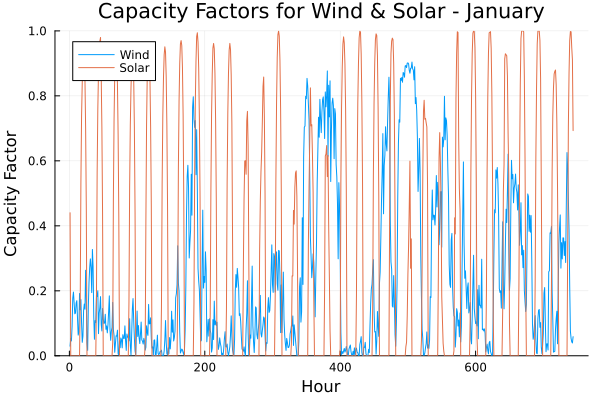

In [44]:
plot(variability.Wind[1:(24*31)], ylims=(0,1), label="Wind")
plot!(variability.Solar[1:(24*31)], ylims=(0,1), label="Solar")
title!("Capacity Factors for Wind & Solar - January")
xaxis!("Hour")
yaxis!("Capacity Factor")

And here's what July (the peak month for demand) looks like...

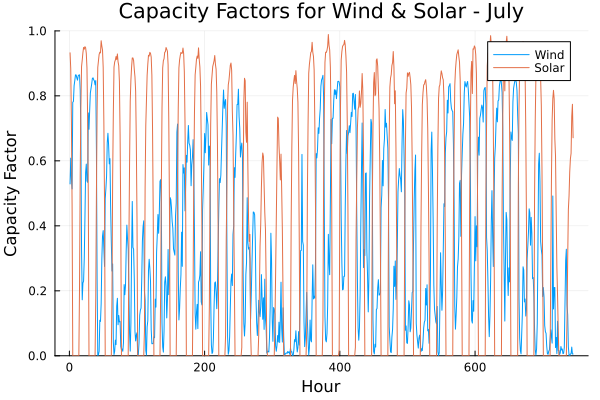

In [45]:
july1 = 24*(31*3+30*2+28)
july31 = 24*(31*4+30*2+28)
plot(variability.Wind[july1:july31], ylims=(0,1), label="Wind")
plot!(variability.Solar[july1:july31], ylims=(0,1), label="Solar")
title!("Capacity Factors for Wind & Solar - July")
xaxis!("Hour")
yaxis!("Capacity Factor")

Now we have to slightly modify our problem formulation. For variable renewable resources $g \in RE$, where $RE$ is the subset $\{Wind, Solar\} \subset G$, the maximum possible generation is now time-dependent and equal to $CAP_g \times cf_{g,h}$ where $cf_{g,h}$ is the capacity factor for resource $g$ in hour $h$. That is, a 100 MW solar farm with an hourly capacity factor of 0.2 (20%) can produce no more than 20 MW in that hour. (We assume these are curtailable, utility-scale wind and solar PV plants that can produce less than this maximum amount of desired).

This yields:

$\begin{align}
\min &\sum_{g \in G} \left(FixedCost_g \times CAP_g +  \sum_{h \in H} VarCost_g \times GEN_{g,h}\right)& \\
&\quad\quad+ \sum_{h \in H} NSECost \times NSE_h &\\[6pt]
&\text{s.t.}&\\[6pt]
& \sum_{g \in G} GEN_{g,h} + NSE_h = Demand_h & \forall \quad h \in H\\[6pt]
& GEN_{g,h} \leq CAP_g & \forall \quad g \notin RE \text{ \& } h \in H\\[6pt]
& GEN_{g,h} \leq CAP_g \times cf_{g,h} & \forall \quad g \in RE \text{ \& } h \in H\\[6pt]
& CAP_{g} \geq 0 & \forall \quad h \in H\\[6pt]
& GEN_{g,h} \geq 0 & \forall \quad g \in G \text{ \& } h \in H\\
& NSE_{h} \geq 0 & \forall \quad h \in H
\end{align}$

In Homework 2, you can code up this version of the generation expansion problem.

## 3. Brownfield expansion and retirement decisions

<img src="img/brownfield.png" style="width: 450px; height: auto" align="left">

The formulation above assumes no existing generating capacity -- a "greenfield" expansion problem.

But realistic planning problems will begin with today's installed capacity and then consider both what to build *and what to retire* to meet future demand at lowest cost. 

The capital expenditure to build existing generators is a *sunk cost*, so this should not factor into the economic decision making as to whether to continue operating a power plant. The relevant decisions have to do only with *avoidable costs*, in this case, ongoing fixed operations and maintenance costs (which we will consider inclusive of any capital expenditure to refurbish or replace aging equipment and continue operating). 

Let's define a formulation for this "brownfield" generation expansion problem with existing capacity retirement decisions and new build capacity expansion decisions.

First, define a new subset of generators $OLD \subset G$ that consists of all existing generators, and an existing capacity parameter $ExistingCap_g \forall g \in OLD$. 

For these resources, we don't have a capacity expansion decision ($CAP_g$), but we do have a retirement decision, $RET_g$, which indicates how much capacity is to be retired before the planning year. 

The $FixedCost_g$ for each existing generator consists only of the ongoing fixed operations and maintenance costs ($FixedOM_g$), with no annuitized investment cost component.

For convenience, let's also define a new subset $NEW \subset G$ that consists of all new build capacity options.

The new formulation is as follows:

$\begin{align}
\min &\sum_{g \in NEW} FixedCost_g \times CAP_g + \sum_{g \in OLD} FixedCost_g \times (ExistingCap_g - RET_g)& \\
&\quad\quad+ \sum_{g\in G}\sum_{h \in H} VarCost_g \times GEN_{g,h} + \sum_{h \in H} NSECost \times NSE_h &\\[6pt]
\end{align}$

$\begin{align}
&\text{s.t.}&\\[6pt]
&\text{Demand balance constraint:}&\\[6pt]
& \sum_{g \in G} GEN_{g,h} + NSE_h = Demand_h & \forall \quad h \in H\\[6pt]
&\text{Capacity constraint for new build thermal:}&\\[6pt]
& GEN_{g,h} \leq CAP_g & \forall \quad g \in NEW \text{ \& } \notin RE \text{ \& } h \in H\\[6pt]
&\text{Capacity constraint for existing thermal:}&\\[6pt]
& GEN_{g,h} \leq ExistingCap_g - RET_g & \forall \quad g \in OLD \text{ \& } \notin RE \text{ \& } h \in H\\[6pt]
&\text{Capacity constraint for new build RE:}&\\[6pt]
& GEN_{g,h} \leq CAP_g \times cf_g & \forall \quad g \in NEW \text{ \& } \in RE \text{ \& } h \in H\\[6pt]
&\text{Capacity constraint for existing RE:}&\\[6pt]
& GEN_{g,h} \leq (ExistingCap_g - RET_g) \times cf_g & \forall \quad g \in OLD \text{ \& } \in RE \text{ \& } h \in H\\[6pt]
&\text{Capacity variable only for new build:}&\\[6pt]
& CAP_{g} \geq 0 & \forall \quad g \in NEW\\[6pt]
&\text{Retirement variable only for existing:}&\\[6pt]
& RET_{g} \geq 0 & \forall \quad g \in OLD\\[6pt]
&\text{Generation and NSE variables:}&\\[6pt]
& GEN_{g,h} \geq 0 & \forall \quad g \in G \text{ \& } h \in H\\
& NSE_{h} \geq 0 & \forall \quad h \in H
\end{align}$

You'll construct this model in Homework 2 as well.